# Chuẩn bị dataset

Import các thư viện cần thiết:

In [20]:
import numpy as np
from matplotlib import pyplot
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn import datasets

Generate dataset circles từ thư viện scikit-learn:

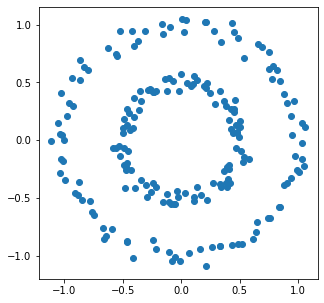

In [21]:
n = 200
data,labels = datasets.make_circles(n_samples = n, factor = 0.5, noise = 0.05)
pyplot.rcParams['figure.figsize'] = (5,5)
pyplot.scatter(data[:,0],data[:,1])
pyplot.show()

# Dựng similarity graph

Xây dựng fully connected graph(sử dụng gaussian similarity function với $\sigma = 1$)

In [22]:
#hàm tính khoảng cách giữa 2 điểm
def distance(point1,point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)



#fca: fully connected adjacent matrix
sigma = 0.125
fca = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        fca[i][j] = np.exp(-(distance(data[i],data[j])**2)/(2*sigma**2))

        
        
        
#plot fully connected graph
pyplot.rcParams['figure.figsize'] = (5,5)
pyplot.scatter(data[:,0],data[:,1],s = 2, zorder = 10)
for i in range(n):
    for j in range(n):
        lx = [data[i][0],data[j][0]]
        ly = [data[i][1],data[j][1]]
        pyplot.plot(lx,ly, color = 'black', linewidth = fca[i][j])
pyplot.show()

Ta thấy rằng dù các cạnh nối giữa hai hình tròn mờ do có trọng số nhỏ. Nhưng giá trị lát cắt để phân chia hai hình tròn này tương đối lớn

Dựng k-nearest neighbor graph với k = 11:

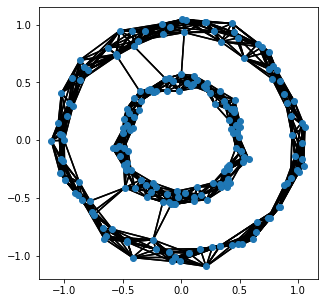

In [23]:
#kna: k-nearest neighbor adjacent matrix
k = 11
val = np.zeros(n)
kna = np.zeros((n,n))

for i in range(n):
    tmp = [x for x in range(n)]
    for j in range(n):
        val[j] = distance(data[i],data[j])
            

    tmp = sorted(range(n), key=lambda x: val[x])
        
    for j in range(k+1):
        kna[i][tmp[j]] = np.exp(-(val[tmp[j]]**2)/2)

            
for i in range(n):
    for j in range(n):
        kna[i][j] = max(kna[i][j],kna[j][i])
        
#plot k-nearest neighbor graph
pyplot.rcParams['figure.figsize'] = (5,5)

pyplot.scatter(data[:,0],data[:,1],zorder = 10)

for i in range(n):
    for j in range(n):
        if (kna[i][j]>0):
            lx = [data[i][0],data[j][0]]
            ly = [data[i][1],data[j][1]]
            pyplot.plot(lx,ly,color = 'black')
pyplot.show()

# Tính ma trận Laplace và áp dụng Spectral clustering

## Tính ma trận Laplace và các eigenvalues

Ta viết hàm tính ma trận Laplace cho các ma trận kề đã tính ở trên và plot các eigenvalues của ma trận Laplace đã tính

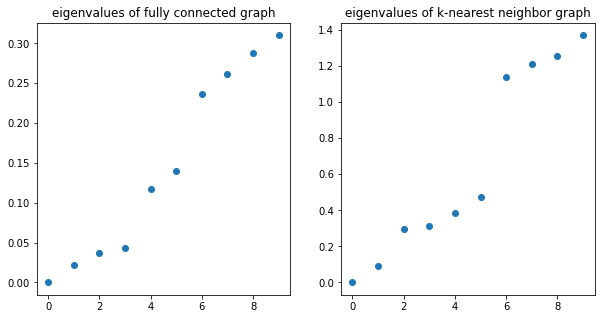

In [24]:
def laplacian(adj):
    matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if (i!=j):
                matrix[i][j] = -adj[i][j]
                matrix[i][i] += adj[i][j]
    return matrix

lapf = laplacian(fca)
lapk = laplacian(kna)

evalf,evecf = np.linalg.eig(lapf)
evalk,eveck = np.linalg.eig(lapk)
evalf.sort()
evalk.sort()


#plot các giá trị riêng của ma trận laplace
pyplot.rcParams['figure.figsize'] = (10,5)
pyplot.subplot(1,2,1).set_title('eigenvalues of fully connected graph')
pyplot.scatter(range(10),evalf[:10])
pyplot.subplot(1,2,2).set_title('eigenvalues of k-nearest neighbor graph')
pyplot.scatter(range(10),evalk[:10])
pyplot.show()

Ở fully connected graph, ta thấy rằng lát cắt để chia hai hình tròn đồng tâm thành hai cụm khác nhau có giá trị lớn nên sử dụng eigengap heuristic không hiệu quả do chênh lệch giữa $\lambda_2$ và $\lambda_3$ không khác nhiều với các chênh lệch khác ở lân cận


Còn ở k-nearest neighbor graph ta có thể dễ dàng nhận ra các eigengap giữa $\lambda_2$ và $\lambda_3$ hoặc giữa $\lambda_6$ và $\lambda_7$. Ta có thể dựa vào đó để thử clustering số cluster có tiềm năng


## Áp dụng Spectral clustering

Vì Spectral Clustering của thư viện scikit-learn sử dụng công thức trọng số cạnh bằng exp(-gamma * d(X,X) ** 2) với d(X,X)là khoảng cách Euclid giữa 2 điểm khác với Gaussian similarity function nên ta sẽ chuyển về Gaussian similarity function bằng cách cho gamma = $\frac{1}{2\sigma^2}$

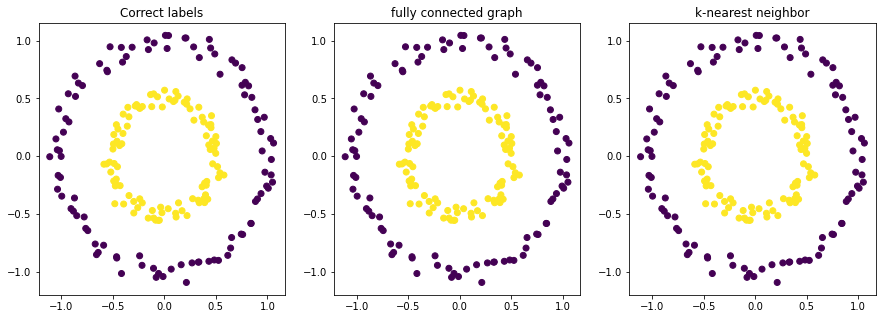

In [25]:
kcluster = SpectralClustering(n_clusters = 2, affinity = 'nearest_neighbors', n_neighbors = 11).fit(data)
#với sigma = 0.125 ta có gamma = 32
fcluster = SpectralClustering(n_clusters = 2, affinity = 'rbf', gamma = 32).fit(data)
#plot kết quả 
pyplot.rcParams['figure.figsize'] = (15,5)
pyplot.subplot(1,3,1).set_title('Correct labels')
pyplot.scatter(data[:,0],data[:,1],c = labels)
pyplot.subplot(1,3,2).set_title('fully connected graph')
pyplot.scatter(data[:,0],data[:,1],c = fcluster.labels_)
pyplot.subplot(1,3,3).set_title('k-nearest neighbor')
pyplot.scatter(data[:,0],data[:,1],c = kcluster.labels_)
pyplot.show()

## So sánh với K-Means

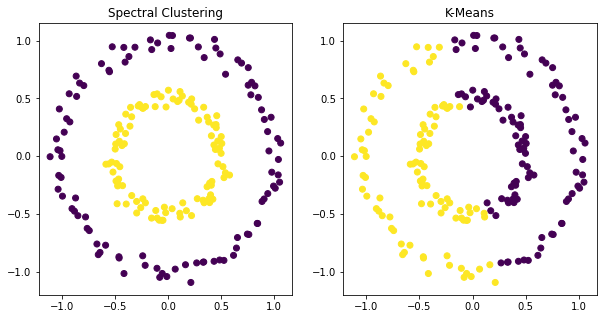

In [26]:
kmeans = KMeans(n_clusters = 2).fit(data)
pyplot.rcParams['figure.figsize'] = (10,5)
pyplot.subplot(1,2,1).set_title('Spectral Clustering')
pyplot.scatter(data[:,0],data[:,1],c = labels)
pyplot.subplot(1,2,2).set_title('K-Means')
pyplot.scatter(data[:,0],data[:,1],c = kmeans.labels_)
pyplot.show()

Ta thấy rằng Spectral clustering có khả năng phân cụm những cụm có hình dạng phức tạp dựa vào mức độ giống nhau giữa các điểm dữ liệu thay vì chỉ chia được các cụm hình cầu như K-Means